<a href="https://colab.research.google.com/github/Shrenik811rp/Chest-xray-project/blob/master/Chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LOGISTIC REGRESSION USING CNN**

Install tensorflow==2.5.0 to get confusion matrix

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

#!pip install tensorflow==2.5.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/xray_dataset/archive.zip"

!cp "{zip_path}" .

!unzip -q archive.zip

!rm archive.zip

In [3]:
dataset_folder = os.listdir("/content/chest_xray")

print(dataset_folder)
#print(np.__version__)


['val', 'train', 'chest_xray', '__MACOSX', 'test']


In [4]:
'''
Folder paths
'''
train_folder = "/content/chest_xray/train"

test_folder = "/content/chest_xray/test"

validation_folder ="/content/chest_xray/val"



In [1]:
#!pip install tensorflow==2.5.0
import tensorflow as tf

print(tf.__version__)


2.5.0


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [10]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
  data = [] 
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
        # Reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [11]:
train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


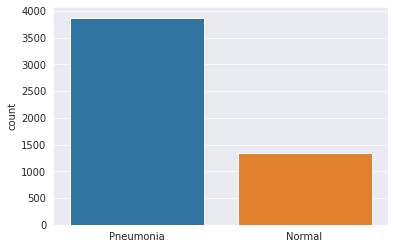

In [12]:
l = []
for i in train:
  if(i[1] == 1):
    l.append("Normal")
  else:
    l.append("Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l)    

Text(0.5, 1.0, 'NORMAL')

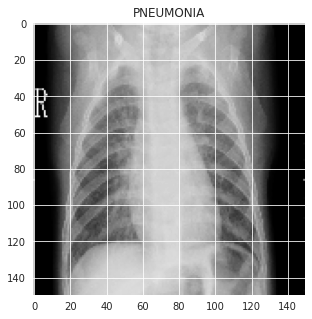

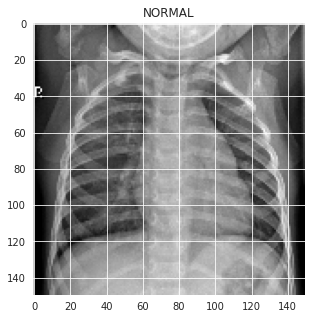

In [13]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [14]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [15]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [16]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [17]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [18]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [71]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) , #32
                    epochs = 5 ,#12
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction]
                    )

Epoch 1/12
163/163 [==============================] - 340s 2s/step - loss: 0.2211 - accuracy: 0.9202 - val_loss: 17.1735 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 341s 2s/step - loss: 0.1754 - accuracy: 0.9369 - val_loss: 3.0273 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 343s 2s/step - loss: 0.1763 - accuracy: 0.9379 - val_loss: 0.4604 - val_accuracy: 0.8125
Epoch 4/12
163/163 [==============================] - 343s 2s/step - loss: 0.1537 - accuracy: 0.9438 - val_loss: 0.7997 - val_accuracy: 0.3750
Epoch 5/12
163/163 [==============================] - 342s 2s/step - loss: 0.1456 - accuracy: 0.9490 - val_loss: 1.7102 - val_accuracy: 0.5625

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/12
163/163 [==============================] - 342s 2s/step - loss: 0.1200 - accuracy: 0.9572 - val_loss: 0.6970 - val_accuracy: 0.7500
Epoch 7/12
163/163 [==============================] - 341s 2

In [72]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")
model.save("cnn.model")

20/20 [==============================] - 9s 437ms/step - loss: 0.3423 - accuracy: 0.8590
Loss of the model is -  0.3422873318195343
20/20 [==============================] - 9s 440ms/step - loss: 0.3423 - accuracy: 0.8590
Accuracy of the model is -  85.89743375778198 %
INFO:tensorflow:Assets written to: cnn.model/assets


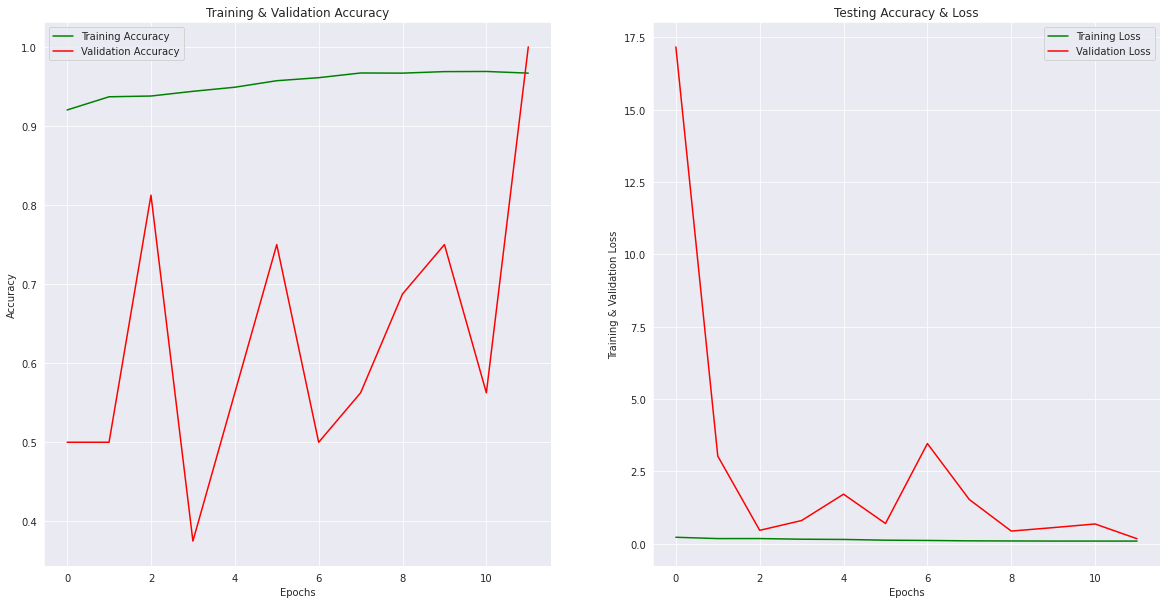

In [73]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [74]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [26]:
tf.__version__  #use 2.5.0 version

'2.5.0'

In [75]:
print(classification_report(y_test,
                            predictions,
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.81      0.88       390
   Normal (Class 1)       0.75      0.94      0.83       234

           accuracy                           0.86       624
          macro avg       0.85      0.87      0.86       624
       weighted avg       0.88      0.86      0.86       624



In [76]:
cm = confusion_matrix(y_test,predictions)
cm

array([[317,  73],
       [ 15, 219]])

In [77]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

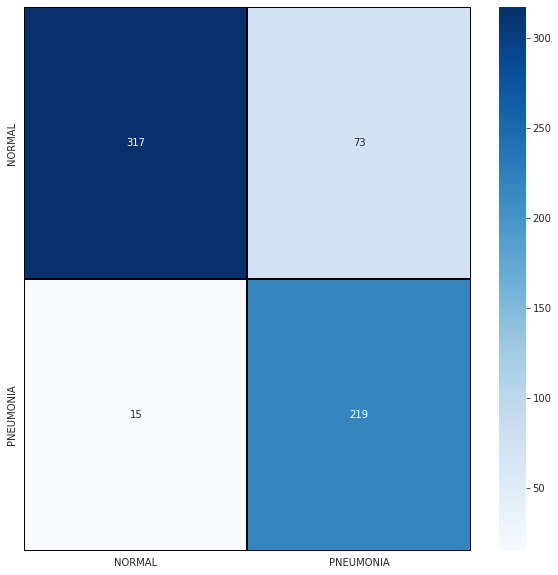

In [78]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues",
            linecolor = 'black' ,
            linewidth = 1 ,
            annot = True,
            fmt='',
            xticklabels = labels,yticklabels = labels)

In [90]:
labels = ["PNEUMONIA","Normal"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (img_size,img_size))
    return new_array.reshape(-1,img_size,img_size, 1)

model = tf.keras.models.load_model("cnn.model") # load model

In [93]:
# extra pneumonia photo from google
prediction = model.predict([prepare("/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")])
print(labels[int(prediction[0])])

Normal


#**SVM**

In [94]:
'''
Folder paths
'''
train_folder = "/content/chest_xray/train"

test_folder = "/content/chest_xray/test"

validation_folder ="/content/chest_xray/val"

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

from tensorflow.keras.regularizers import l2

In [97]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
  data = [] 
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
        # Reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [98]:
train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


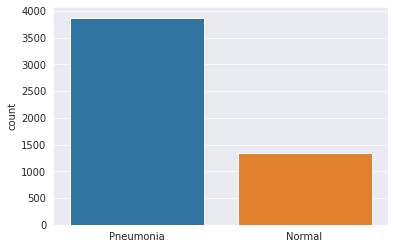

In [99]:
l = []
for i in train:
  if(i[1] == 1):
    l.append("Normal")
  else:
    l.append("Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

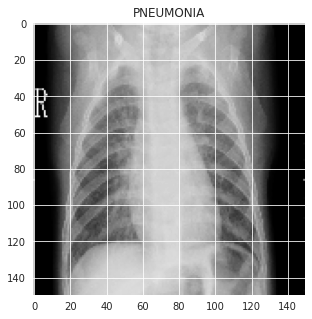

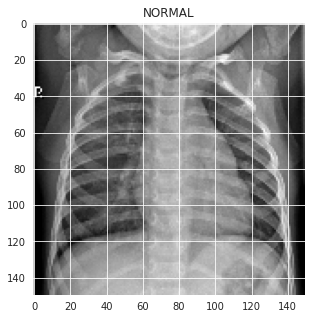

In [100]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [101]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [102]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [103]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [104]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [105]:
svm_model = Sequential()
svm_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
svm_model.add(BatchNormalization())
svm_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
svm_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
svm_model.add(Dropout(0.1))
svm_model.add(BatchNormalization())
svm_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
svm_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
svm_model.add(BatchNormalization())
svm_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
svm_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
svm_model.add(Dropout(0.2))
svm_model.add(BatchNormalization())
svm_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
svm_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
svm_model.add(Dropout(0.2))
svm_model.add(BatchNormalization())
svm_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
svm_model.add(Flatten())
svm_model.add(Dense(units = 128 , activation = 'relu'))

svm_model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                activation='linear'))

svm_model.compile(optimizer = "adam" , loss = 'hinge' , metrics = ['accuracy'])
svm_model.summary()
svm_model.save("svm.model")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 38, 38, 64)       

In [106]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [107]:
history = svm_model.fit(datagen.flow(x_train,y_train, batch_size = 32) , #32
                    epochs = 2 ,#5 or 10
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction]
                    )

Epoch 1/2
163/163 [==============================] - 339s 2s/step - loss: 0.4150 - accuracy: 0.8715 - val_loss: 8.0845 - val_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 336s 2s/step - loss: 0.2130 - accuracy: 0.9156 - val_loss: 3.6961 - val_accuracy: 0.5000


In [108]:
print("Loss of the model is - " , svm_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , svm_model.evaluate(x_test,y_test)[1]*100 , "%")


20/20 [==============================] - 9s 443ms/step - loss: 2.0146 - accuracy: 0.6250
Loss of the model is -  2.01460862159729
20/20 [==============================] - 9s 445ms/step - loss: 2.0146 - accuracy: 0.6250
Accuracy of the model is -  62.5 %


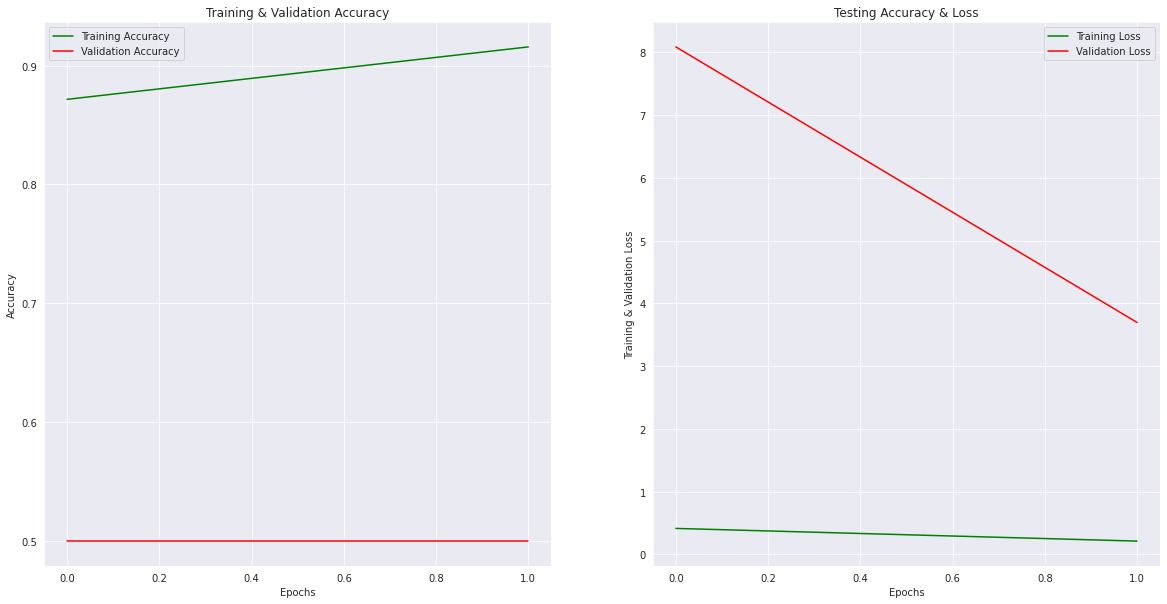

In [117]:
epochs = [i for i in range(2)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [118]:
predictions = svm_model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [119]:
print(classification_report(y_test,
                            predictions,
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
cm = confusion_matrix(y_test,predictions)
cm

array([[390,   0],
       [234,   0]])

In [121]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

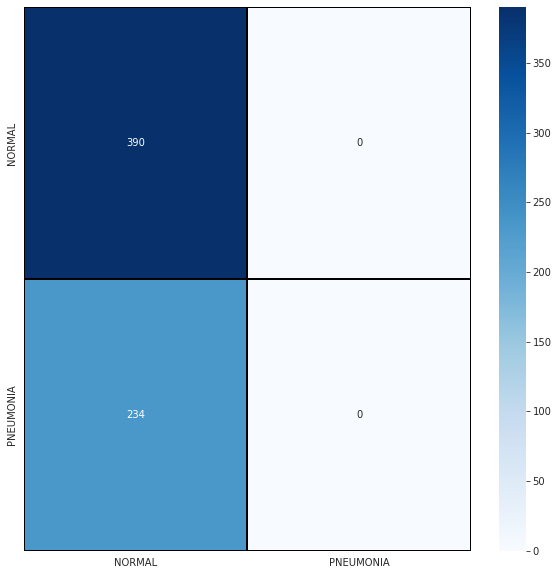

In [122]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues",
            linecolor = 'black' ,
            linewidth = 1 ,
            annot = True,
            fmt='',
            xticklabels = labels,yticklabels = labels)

In [123]:
labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (img_size,img_size))
    return new_array.reshape(-1 ,img_size,img_size, 1)

svm_model = tf.keras.models.load_model("svm.model") # load model

In [124]:
# extra pneumonia photo from google
prediction = svm_model.predict([prepare("/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg")])
print(prediction)

if prediction > 0:
  print(labels[0])
else:
  print(labels[1])

[[0.728848]]
NORMAL


#**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
import os

import matplotlib.pyplot as plt

In [ ]:

image_size= 32

dir_base='/content/chest_xray'
test_dir = '{}/{}'.format(dir_base, 'test')
train_dir = '{}/{}'.format(dir_base, 'train')
val_dir = '{}/{}'.format(dir_base, 'val')

test_dir_normal_cases = '{}/{}/{}'.format(dir_base, 'test','NORMAL')
train_dir_normal_cases = '{}/{}/{}'.format(dir_base, 'train','NORMAL')
val_dir_normal_cases = '{}/{}/{}'.format(dir_base, 'val','NORMAL')

test_dir_pneumonia_cases = '{}/{}/{}'.format(dir_base, 'test','PNEUMONIA')
train_dir_pneumonia_cases = '{}/{}/{}'.format(dir_base, 'train','PNEUMONIA')
val_dir_pneumonia_cases = '{}/{}/{}'.format(dir_base, 'val','PNEUMONIA')





In [ ]:
def get_data(path,label,data_type,process_flipped):
  result = []
  items = os.listdir(path)
  for i in items:
    img_path = '{}/{}/{}/{}'.format(dir_base,data_type,label,i)
    result.append((get_image_arr(img_path),label))
    if process_flipped == True:
      result.append((get_flipped_image_arr(img_path),label))
  return pd.DataFrame(result, columns=['image', 'label'],index=None)

In [ ]:
def get_flipped_image_arr(path):
  original = cv2.imread(path) 
  img = cv2.flip(original, 1)
  img = cv2.resize(img, (image_size, image_size),interpolation = cv2.INTER_AREA).reshape(1,-1)
  return img

In [ ]:
def get_image_arr(path):
  img = cv2.imread(path) 
  img = cv2.resize(img, (image_size, image_size),interpolation = cv2.INTER_AREA).reshape(1,-1)
  return img

In [ ]:
def show_plot(k_values,accuracy_values):
  fig = plt.figure()
  fig.subplots_adjust(top=0.8)
  ax1 = fig.add_subplot()
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('K value')
  plt.plot(k_values,accuracy_values,label='Accuracy for k params')
  plt.scatter(k_values,accuracy_values,c=k_values,alpha=1)
  plt.legend()
  plt.show()

In [ ]:


def show_confusion_matrix(model,x,y):
  disp = plot_confusion_matrix(model, x, y,
                               cmap=plt.cm.Blues,
                               normalize= None, values_format = '.2f')
  plt.show()



In [ ]:
data_normal = get_data(train_dir_normal_cases,'NORMAL','train',True)
data_pneumonia = get_data(train_dir_pneumonia_cases,'PNEUMONIA','train',False)


In [ ]:
data = pd.concat([data_normal,data_pneumonia])
images = data.image
y = data.label

X = []
for i in images.values:
    X.append(i[0])
X = np.array(X)

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.70,
                                                    random_state=30)
print('X train shape:',X_train.shape)
print('Y train shape:',y_train.shape)

print('X train shape:',X_test.shape)
print('Y train shape:',y_test.shape)


X train shape: (1967, 3072)
Y train shape: (1967,)
X train shape: (4590, 3072)
Y train shape: (4590,)


Accuracy for k=5: 0.9411764705882353


              precision    recall  f1-score   support

      NORMAL       0.96      0.90      0.93      1857
   PNEUMONIA       0.93      0.97      0.95      2733

    accuracy                           0.94      4590
   macro avg       0.94      0.93      0.94      4590
weighted avg       0.94      0.94      0.94      4590



Accuracy for k=10: 0.9405228758169935


              precision    recall  f1-score   support

      NORMAL       0.94      0.91      0.93      1857
   PNEUMONIA       0.94      0.96      0.95      2733

    accuracy                           0.94      4590
   macro avg       0.94      0.94      0.94      4590
weighted avg       0.94      0.94      0.94      4590



Accuracy for k=20: 0.9396514161220043


              precision    recall  f1-score   support

      NORMAL       0.95      0.90      0.92      1857
   PNEUMONIA       0.93      0.97      0.95      2733

    accuracy                           0.94      4590
   ma

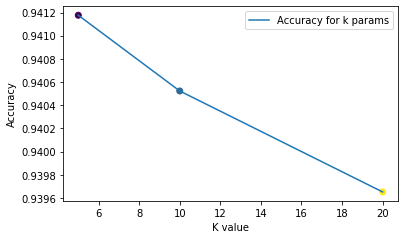

In [ ]:
k_values = [5,10,20]
accuracy_values = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, predictions)
    accuracy_values.append(acc)
    print('Accuracy for k={}:'.format(str(k)),acc)
    print('\n')
    print(classification_report(y_test, predictions))
    print('=========================================================')
    print('\n')
show_plot(k_values,accuracy_values)


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
#Load test data
test_data_normal = get_data(test_dir_normal_cases,'NORMAL','test',False)
test_data_pneumonia = get_data(test_dir_pneumonia_cases,'PNEUMONIA','test',False)

test_data_total = pd.concat([test_data_normal,test_data_pneumonia])

y_test_data = test_data_total.label

X_test_data = []
for i in test_data_total.image.values:
    X_test_data.append(i[0])
    
X_test_data = np.array(X_test_data)

Accuracy for test 0.7980769230769231
              precision    recall  f1-score   support

      NORMAL       0.94      0.49      0.65       234
   PNEUMONIA       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



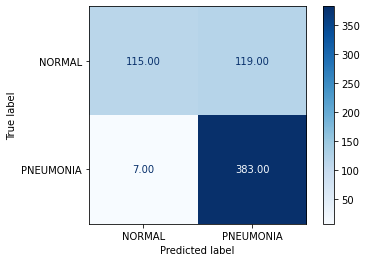

In [ ]:


predictions_test = knn_model.predict(X_test_data)
acc_test = metrics.accuracy_score(y_test_data, predictions_test)
print('Accuracy for test',acc_test)
print(classification_report(y_test_data, predictions_test))
show_confusion_matrix(knn_model,X_test_data,y_test_data)



In [ ]:
print(predictions_test[:5])

['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'PNEUMONIA']
